In [5]:
# розглянемо задачу відповіді на запитання (question answering, QA) з використанням архітектури трансформер.
# Це завдання має багато різновидів, але той, на якому ми зосередимося в цьому розділі, називається екстрактивною відповіддю на запитання (extractive question answering).
# Воно передбачає постановку запитань до документа й визначення відповідей у вигляді фрагментів тексту в самому документі.
# Ми донавчимо модель BERT на наборі даних SQuAD (альтернативне посилання).
# Stanford Question Answering Dataset (SQuAD) — це набір даних для розуміння прочитаного (reading comprehension), що складається із запитань,
# поставлених до набору статей Вікіпедії, де відповіддю на кожне запитання є сегмент тексту, або уривок; або ж запитання може не мати відповіді.

# У налаштуваннях kaggle notebook виберіть пристрій GPU P100. Ви можете запустити виконання коду на ніч, щоб уранці переглянути отримані результати.
!pip install rouge_score
!pip install evaluate

In [6]:
import warnings
warnings.filterwarnings('ignore')

import gc
import random
import collections

import numpy as np

from datasets import load_dataset
from datasets import DatasetDict

from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader

from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import AutoModelForQuestionAnswering
from transformers import DataCollatorForSeq2Seq
from transformers import AdamW
from transformers import default_data_collator

import evaluate

import nltk

In [7]:
def sample_n_examples(dataset, p):
    n = int(len(dataset) * p)
    indices = random.sample(range(len(dataset)), n)
    return dataset.select(indices)

In [8]:
device = "cuda" if torch.cuda.is_available() else None   # Визначимо пристрій, на якому будемо проводити розрахунки

# Question answering
## Завантаження даних



In [9]:
raw_datasets = load_dataset("squad")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [10]:
# p = 0.4
# # Sample N examples from each split in the DatasetDict
# sampled_dataset_dict = {split: sample_n_examples(dataset, p) for split, dataset in raw_datasets.items()}
# sampled_dataset_dict

In [11]:
# У нас є всі необхідні дані в полях context, question і answers. Переглянемо перший приклад у нашому наборі даних
print("Context: ", raw_datasets["train"][0]["context"])
print("Question: ", raw_datasets["train"][0]["question"])
print("Answer: ", raw_datasets["train"][0]["answers"])

Context:  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question:  To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer:  {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}


In [12]:
# Поля context і question дуже прості у використанні. Поле answers трохи складніше, оскільки воно поєднує словник із двома полями, які є списками.
# Саме такого формату очікує метрика squad під час оцінювання. Трохи далі ми розглянемо, як вона розраховується.
# Поле text досить очевидне, а поле answer_start містить індекс початкового символу кожної відповіді в контексті.
# Під час навчання можлива лише одна відповідь. Ми можемо перевірити це за допомогою методу Dataset.filter(). Спробуємо знайти поля answers, що містять більше одного значення в полі text.
raw_datasets["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

In [13]:
# Для тестування, однак, є кілька можливих відповідей для кожної вибірки, які можуть бути однаковими або різними:
print(raw_datasets["validation"][0]["answers"])
print(raw_datasets["validation"][2]["answers"])

{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}
{'text': ['Santa Clara, California', "Levi's Stadium", "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."], 'answer_start': [403, 355, 355]}


## Підготовка навчальних даних

In [14]:
# Почнемо з попередньої обробки навчальних даних.
# Найскладніше буде згенерувати мітки для відповідей на запитання, які будуть початковою та кінцевою позиціями токенів, що відповідають відповіді в контексті.
# Але не будемо забігати наперед. По-перше, нам потрібно перетворити текст на вході в ідентифікатори, які модель зможе зрозуміти, за допомогою токенізатора:
model_checkpoint = "bert-base-cased"

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Мітки, які ми передбачатимемо, будуть індексами токенів, що починають і закінчують відповідь. Моделі буде поставлено завдання передбачити по одному початковому й кінцевому логіту на кожен токен у вхідних даних, як наведено нижче:

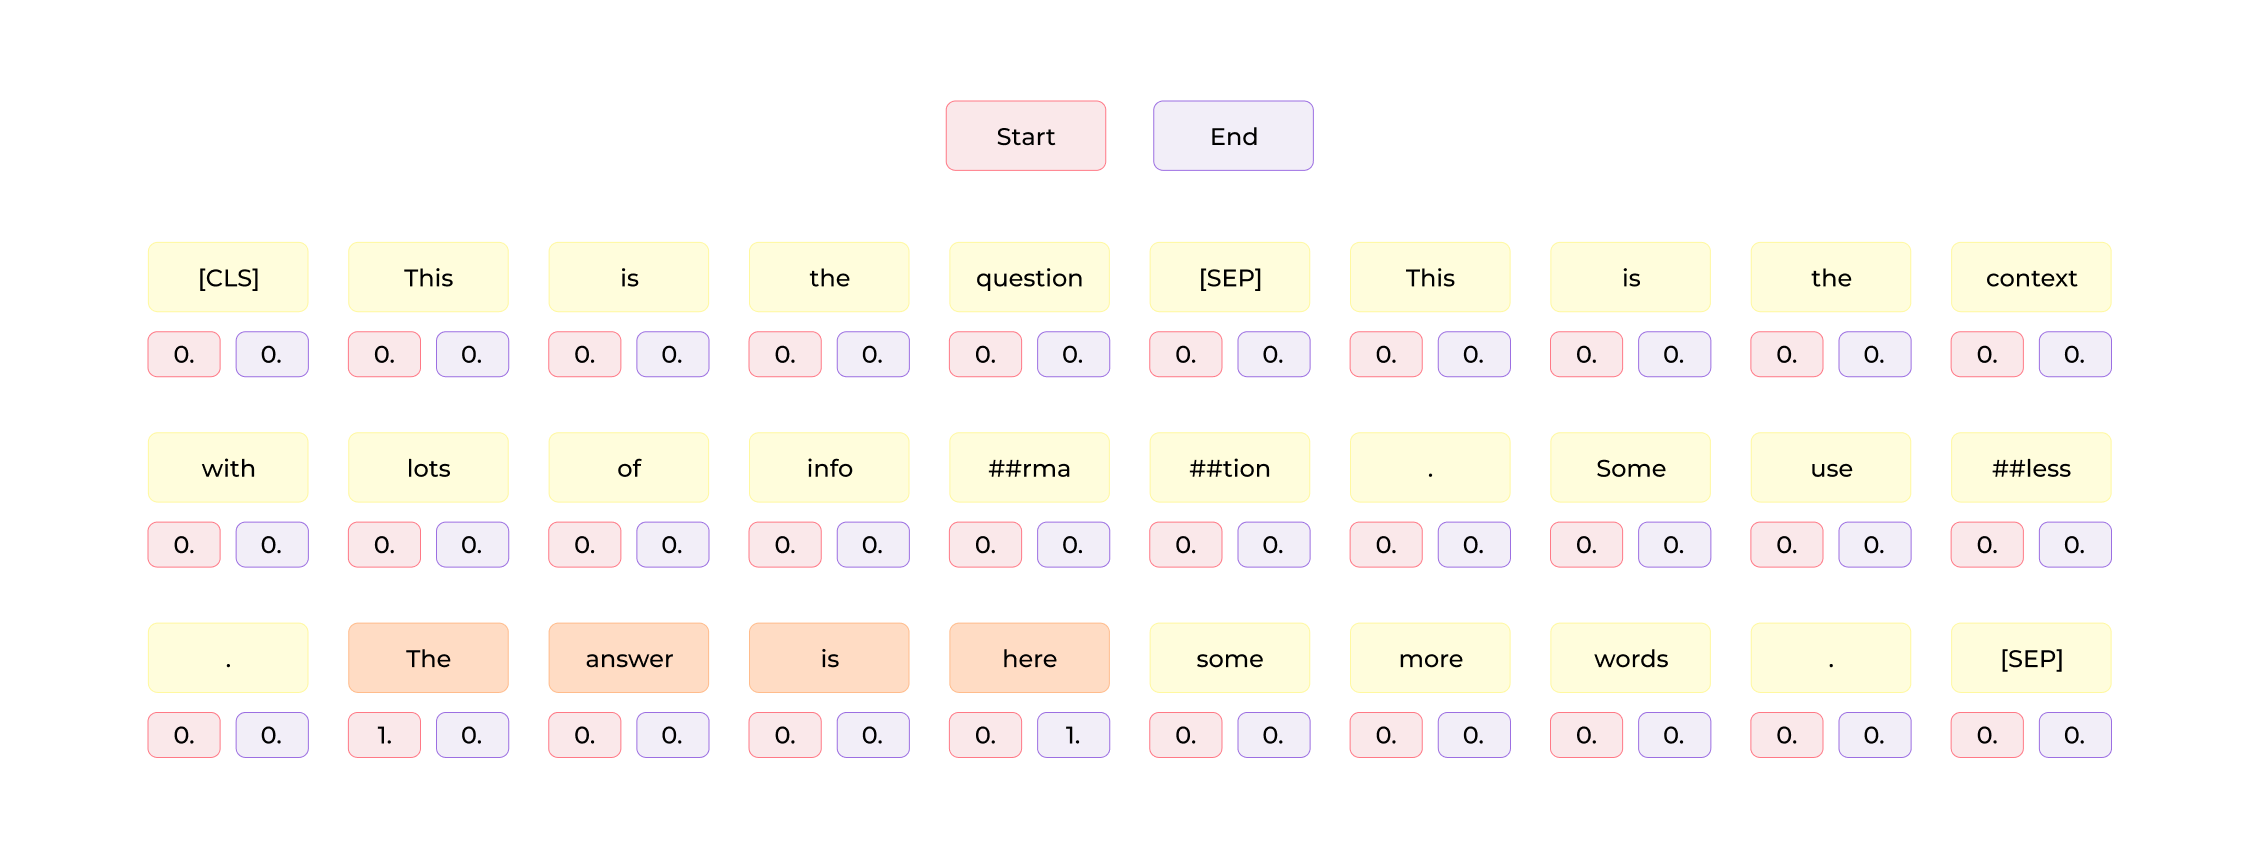

In [15]:
context = raw_datasets["train"][0]["context"]
question = raw_datasets["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building \' s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ), is a simple, modern stone statue of Mary. [SEP]'

У нашому наборі даних довжина документа (контексту) не є великою. Однак, зустрічаються тексти, довжина яких перевищує розмір контекстного вікна (context window) моделі.



Щоб опрацьовувати довгі контексти, ми будемо розбивати їх на менші, створюючи кілька навчальних ознак на основі одного прикладу з нашого набору даних, із ковзним вікном між ними. Під використанням ковзного вікна мається на увазі, що кожен сегмент частково перекривається з попереднім і наступним сегментом на довжину ковзного вікна.



Давайте розглянемо приклад розбиття одного контексту на декілька менших.



Тут ми використовуємо наступні параметри нашого токенізатора:

- max_length - для встановлення максимальної довжини (тут 100);

- truncation=«only_second» - щоб обрізати контекст (який знаходиться у другій позиції), коли питання з контекстом занадто довге;

- stride - щоб задати кількість токенів, що перекриваються між двома послідовними фрагментами (тут 50);

- return_overflowing_tokens=True - щоб повідомити токенізатору, що ми хочемо отримувати інформацію про токени, які перевищують максимальну довжину контекстного вікна.

In [16]:
# У нашому наборі даних довжина документа (контексту) не є великою. Однак, зустрічаються тексти, довжина яких перевищує розмір контекстного вікна (context window) моделі.
# Щоб опрацьовувати довгі контексти, ми будемо розбивати їх на менші, створюючи кілька навчальних ознак на основі одного прикладу з нашого набору даних, із ковзним вікном між ними.
# Під використанням ковзного вікна мається на увазі, що кожен сегмент частково перекривається з попереднім і наступним сегментом на довжину ковзного вікна.
# Давайте розглянемо приклад розбиття одного контексту на декілька менших.
# Тут ми використовуємо наступні параметри нашого токенізатора:
 # - max_length - для встановлення максимальної довжини (тут 100);
 # - truncation=«only_second» - щоб обрізати контекст (який знаходиться у другій позиції), коли питання з контекстом занадто довге;
 # - stride - щоб задати кількість токенів, що перекриваються між двома послідовними фрагментами (тут 50);
 # - return_overflowing_tokens=True - щоб повідомити токенізатору, що ми хочемо отримувати інформацію про токени, які перевищують максимальну довжину контекстного вікна.

inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second", # truncates only context
    stride=50, # the number of overlapping tokens between two successive chunks
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids)); print()

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building ' s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basi [SEP]

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin [SEP]

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Next to the Main Building is t

In [17]:
# Як бачимо, наш приклад було розбито на чотири, кожен з яких містить запитання та частину контексту.

# Зверніть увагу, що відповідь на питання («Bernadette Soubirous») з'являється лише у третьому й останньому контекстах, тому, працюючи з довгими контекстами таким чином,
# ми створимо кілька навчальних прикладів, у яких відповідь не буде включена в контекст.

# Для цих прикладів мітками будуть start_position = end_position = 0.
# Ми також встановимо ці мітки у випадку, коли відповідь було урізано так, що ми маємо лише її початок (або кінець).
# У прикладах, де відповідь повністю відповідає контексту, мітки будуть індексом токена, з якого починається відповідь, та індексом токена, яким вона закінчується.

# Набір даних надає нам початковий символ відповіді в контексті, а додавши довжину відповіді, ми можемо знайти кінцевий символ у контексті.
# Щоб зіставити ці дані з індексами токенів, нам потрібно буде використати відображення зі зсувом (offset mappings).

# Offset mappings у контексті токенізації — це механізм, що дозволяє зіставляти позиції токенів у токенізованому тексті з їхніми початковими позиціями в оригінальному тексті.
# Це особливо корисно для задач NLP, таких як розпізнавання іменованих сутностей (NER), питання-відповідь (QA), або виділення сутностей, де важливо знати точні позиції слів у вихідному тексті.

# Коли текст токенізується, кожен токен отримує відповідний offset — це початкова й кінцева позиції токена у вихідному тексті. Наприклад:
# Оригінальний текст: «Hello, world!»  # Токенізований текст: [«Hello», «,», «world», «!»]
# Offset mappings для кожного токена будуть виглядати так:
    # «Hello»: (0, 5)
    # «,»: (5, 6)
    # «world»: (7, 12)
    # «!»: (12, 13)
# У задачах QA offset mappings допомагають точно вказати місце в тексті, де знаходиться відповідь на запитання.
# Ми можемо попросити наш токенізатор повернути їх, передавши return_offsets_mapping=True:

inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [18]:
# Оскільки тут ми токенізували лише один приклад, ми отримаємо список з 0:
inputs["overflow_to_sample_mapping"]

[0, 0, 0, 0]

In [19]:
# Але якщо ми токенізуємо більше прикладів, це стане більш корисним:
inputs = tokenizer(
    raw_datasets["train"][2:6]["question"],
    raw_datasets["train"][2:6]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 19 features.
Here is where each comes from: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3].


In [20]:
answers = raw_datasets["train"][2:6]["answers"]
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

start_positions, end_positions

([83, 51, 19, 0, 0, 64, 27, 0, 34, 0, 0, 0, 67, 34, 0, 0, 0, 0, 0],
 [85, 53, 21, 0, 0, 70, 33, 0, 40, 0, 0, 0, 68, 35, 0, 0, 0, 0, 0])

In [21]:
idx = 0
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")

Theoretical answer: the Main Building, labels give: the Main Building


In [22]:
# Створимо функцію попередньої обробки даних, яку застосуємо до всього набору навчальних даних.
# Ми додамо кожній ознаці максимальну довжину, оскільки більшість контекстів будуть довгими (і відповідні вибірки будуть розбиті на кілька ознак):

max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [23]:
# Зверніть увагу, що ми визначили дві константи для визначення максимальної довжини, а також довжини ковзного вікна, і що ми додали невелике очищення перед токенізацією.
# Деякі питання в наборі даних SQuAD мають зайві пробіли на початку і в кінці, які нічого не додають
# (і займають місце при токенізації, якщо ви використовуєте модель на зразок RoBERTa), тому ми видалили ці зайві пробіли.

# Щоб застосувати цю функцію до всієї навчальної вибірки, ми використовуємо метод Dataset.map() з прапором batched=True.
# Це необхідно, бо ми змінюємо довжину набору даних (оскільки один приклад може давати кілька навчальних ознак):

train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset)

(87599, 88729)

## Підготовка валідаційних даних

In [24]:
# Як бачимо, попередня обробка додала приблизно 1 000 ознак. Тепер наш навчальний набір готовий до використання!

# Попередня обробка даних валідації буде дещо простішою, оскільки нам не потрібно генерувати мітки (якщо тільки ми не хочемо обчислити функцію втрат валідації,
# але це число не допоможе нам зрозуміти, наскільки хороша модель). Найкращою буде інтерпретація прогнозів моделі в діапазони вихідного контексту.

# Для цього нам просто потрібно буде зберігати offset mappings і спосіб зіставляти кожну створену ознаку з оригінальним прикладом, з якого вона походить.
# Оскільки в оригінальному наборі даних є стовпчик ID, ми використаємо його.

# Єдине, що ми зробимо додатково, це трохи почистимо offset mappings. Вони міститимуть зміщення для питання й контексту, але на етапі постобробки ми не зможемо дізнатися,
# яка частина вхідних ідентифікаторів відповідає контексту, а яка — питанню (метод sequence_ids(), який ми використовували, доступний лише для виводу токенізатора).

# Отже, ми встановимо зміщення, що відповідають питанню, у значення None:

def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [25]:
# Ми можемо застосувати цю функцію до всього набору даних для валідації:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

(10570, 10822)

## Етап тренування

### Визначення метрики



Набір даних SQuAD має спеціалізовану метрику, яка дає змогу оцінити якість моделі. Метрика squad забезпечує декілька ключових показників для оцінки якості моделей питання-відповіді.



Exact Match (EM) — це метрика, яка визначає, чи точно відповідає передбачена відповідь моделі правильній відповіді в тексті. Для кожного запитання й відповіді модель генерує відповідь, яку потім порівнюють з еталонною відповіддю. Якщо відповідь моделі й еталонна відповідь повністю збігаються, це вважається точною відповіддю.



EM є бінарним показником: 1 (успіх) або 0 (неуспіх). Якщо відповідь моделі повністю збігається з еталонною відповіддю, EM дорівнює 1, інакше — 0.



Середній EM для всіх запитань у тестовому наборі використовується для оцінки загальної точності моделі. Це є простим і прямим способом виміряти, наскільки часто модель надає точні відповіді.



F1 Score — це метрика, яка враховує як precision, так і recall відповіді. Вона є більш детальною й інформативною, ніж EM, оскільки оцінює часткові збіги між відповіддю моделі та еталонною відповіддю.



Precision розраховується як відношення кількості правильно передбачених слів (або токенів) до загальної кількості слів, передбачених моделлю. Тобто скільки з тих слів, які модель вважала правильними, насправді є правильними.



Recall розраховується як відношення кількості правильно передбачених слів до загальної кількості слів в еталонній відповіді. Тобто скільки з правильних слів в еталонній відповіді було знайдено моделлю.



Середній F1 Score для всіх запитань у тестовому наборі використовується для оцінки загальної якості відповіді моделі. F1 Score є корисним для оцінки часткових збігів, що може бути особливо важливим у випадках, коли точні відповіді не завжди можливі або не є єдиними можливими правильними відповідями.



In [26]:
# Завантажимо об’єкт метрики.
metric = evaluate.load("squad")

## Підготовка до тренування

In [27]:
# Спочатку нам потрібно створити DataLoaders з наших наборів даних.
# Ми встановлюємо формат цих наборів даних на torch і видаляємо стовпці з валідаційного набору, які не використовуються моделлю.
# Потім ми можемо використати default_data_collator, наданий Transformers, як collate_fn і перемішати навчальний набір, але не валідаційний:

train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=32
)

In [28]:
# Визначимо оптимізатор.
optimizer = AdamW(model.parameters(), lr=2e-5)

In [29]:
# Визначимо додаткові гіперпараметри моделі.
n_best = 20
max_answer_length = 30
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

In [30]:
# Визначимо папку, в яку будемо зберігати натреновану модель.
output_dir = '/kaggle/working/bert-finetuned-squad.pt'

In [31]:
# Визначимо функцію розрахунку метрики.
# Тут example_to_features створює словник, де кожен example_id зіставляється зі списком індексів, що відповідають цьому прикладу.
# Для кожного прикладу з examples код витягує його ідентифікатор і текст контексту.
# Для кожного індексу ознак, пов'язаних з прикладом, витягуються логіти початку та кінця відповіді, а також offsets mapping.
# Індекси для найкращих можливих початків і закінчень відповіді вибираються на основі логітів.
# Відповіді створюються на основі комбінацій початкових і кінцевих індексів за умови, що вони відповідають критеріям (довжина і межі).
# Вибирається відповідь з найвищим балом логіту й додається до списку передбачених відповідей.
# Обчислюється метрика якості за допомогою функції metric.compute, яка порівнює передбачені відповіді з еталонними відповідями.

def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)


In [ ]:
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []

    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

        start_logits.append(outputs.start_logits.cpu().numpy())
        end_logits.append(outputs.end_logits.cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics = compute_metrics(
        start_logits, end_logits, validation_dataset, raw_datasets["validation"]
    )
    print(f"epoch {epoch}:", metrics)

    model.save_pretrained(output_dir)

  0%|          | 0/16638 [00:00<?, ?it/s]

In [ ]:
# Метрика Exact Match (EM) зросла з 78.90% до 80.88%. Це показує, що модель з часом покращує свою здатність надавати точні відповіді, які повністю збігаються з еталонними.
# F1 Score зросла з 86.95% до 88.15%. Це свідчить про те, що модель також покращує точність і повноту відповідей — краще знаходить релевантні частини тексту.
# З огляду на те, що модель покращує свої результати з кожною епохою, можна розглянути можливість додаткового тренування для досягнення ще кращих результатів,
# якщо це є можливим і не призводить до перенавчання.
# Також корисно провести аналіз помилок, щоб зрозуміти типи запитань або контекстів, з якими модель має труднощі, і відповідно корегувати дані або методи навчання.